In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [14]:
%matplotlib inline

In [15]:
data = pd.read_csv("/Users/anushavan/Desktop/Study/\
Data_Science/Springboard/Capstone_1/data/new_buildings.csv", 
                parse_dates=['Pre- Filing Date','Fully Paid', 
                            'Approved','Fully Permitted','SIGNOFF_DATE'])

/Users/anushavan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118461 entries, 0 to 118460
Data columns (total 23 columns):
Borough                          118461 non-null object
Building Type                    118461 non-null object
eFiling Filed                    49594 non-null object
Applicant Professional Title     118456 non-null object
Professional Cert                84910 non-null object
Pre- Filing Date                 118461 non-null datetime64[ns]
Fully Paid                       117514 non-null datetime64[ns]
Approved                         70616 non-null datetime64[ns]
Fully Permitted                  62940 non-null datetime64[ns]
Total Est. Fee                   118461 non-null object
Proposed Zoning Sqft             118461 non-null int64
Proposed No. of Stories          118461 non-null int64
Proposed Height                  118461 non-null int64
Proposed Dwelling Units          68282 non-null object
Proposed Occupancy               79917 non-null object
Zoning Dist1              

### Clean up the dataframe

* converting all column names to *title case*, <br> 
* converting numeric data into numeric form by removing dollar signs and converting to intiger, <br> 
* creating a **"Duration"** column measuring the duration of the approval process as the difference between the "Approved" and "Fully Paid" columns <br> 
* creating subsets of data to hold normal values, values that are below 0 (meaningless) and zero values.
* Transform "Boroughs" into category to increase the speed of execution.

In [17]:
# Convert all data columns to Title Case
data.columns = data.columns.str.title()

# Convert Total Est. Fee to float data and remove $ symbol 
data['Total Est. Fee']= [float(c.replace('$','')) for c in data['Total Est. Fee']]

In [18]:
# Convert Proposed Dwelling Units to integers
data['Proposed Dwelling Units'] = (pd.to_numeric(data
                                  ['Proposed Dwelling Units'], errors='coerce'))


In [19]:
# Create a Duration column and convert it to integers (instead of days)
data['Duration'] = (data['Approved'] - data['Fully Paid']).dt.days

In [20]:
# Subset of data where the Duration is more than 0 days
data = data[data['Duration'] > 0]

# Subset of data where the Duration is less then 0 days
odd_data = data[data['Duration'] < 0]

# Subset of data where the Duration is 0 days
zero_data = data[data['Duration'] == 0]

In [21]:
# transform the Boroughs into categories for faster analysis.
data['Borough'] = data['Borough'].astype('category')

#### Dealing with blank (NaN/NaT) values

converting the NaN values to N string indicating No.

In [22]:
# Column Efiling Filed: replace the NaN values with N (No)
data['Efiling Filed'] = data['Efiling Filed'].fillna('N')

In [23]:
data['Professional Cert'] = data['Professional Cert'].fillna('N')

##### Potential columns to drop
The column "Proposed Dwelling Units" has 50392 not null values.

The columnn "Fully Permitted" has 7070 NaT entries.


##### Drop rows
There are 2 rows in the "Applicant Professional Title" column that are blank. Assigned them
to del_rows variable and deleted. 

There are also 2 rows in the Processional Cert column that are not Y or N, they should be dropped.

In [59]:
del_rows = data[data['Applicant Professional Title'].isnull()].index
data.drop(del_rows, inplace=True)
data = (data.drop(data[(data['Professional Cert'] == 'J') | 
                            (data['Professional Cert'] == 'R')].index))

### Analysis of data

Createing:
1. histograms (for categorical variables)
2. bar charts (for continuous variables) and 
3. boxplots for categorical variables (x axis) and a continuous variable (y axis).


,Borough
count,5.000000
mean,11815.600000
std,7478.298824
min,2224.000000
25%,7417.000000
50%,11360.000000
75%,17063.000000
max,21014.000000


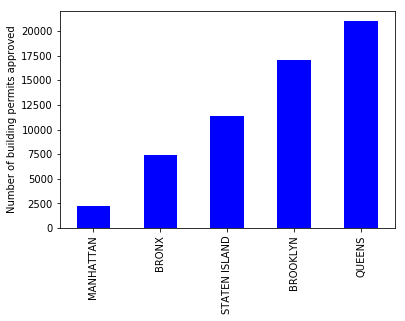

In [29]:
# create a histogram for the # of building permits issued by Borough
ax = data['Borough'].value_counts().sort_values().plot(kind='bar', color = 'b')
ax.set_ylabel('Number of building permits approved')
ax.set_xlabel('')
pd.DataFrame(data['Borough'].value_counts().describe())

Text(0.5,1,'Duration by Borough')

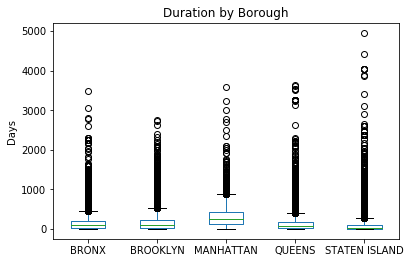

In [30]:
# Create a boxplot of Building Type Duration.
ax = data.boxplot(column=['Duration'], by=['Borough'])
plt.suptitle('')
ax.set_xlabel('')
ax.set_ylabel('Days')
ax.grid(False)
ax.set_title('Duration by Borough')
plt.tight_layout()

,Building Type
count,2.000000
mean,29539.000000
std,18063.749832
min,16766.000000
25%,23152.500000
50%,29539.000000
75%,35925.500000
max,42312.000000


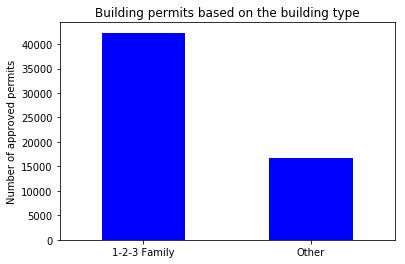

In [31]:
# Create a bar plot of Building Type and include a statistical analysis.
ax = data['Building Type'].value_counts().plot(kind='bar', color='b')
ax.set_xticklabels(['1-2-3 Family', 'Other'],rotation=360)
ax.set_title('Building permits based on the building type')
ax.set_ylabel('Number of approved permits')
pd.DataFrame(data['Building Type'].value_counts().describe())

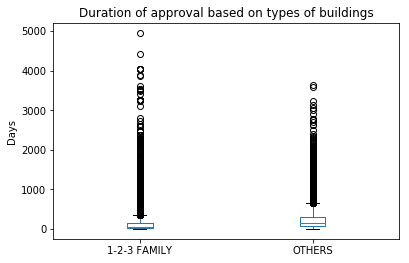

In [32]:
# Create a boxplot of Building Type Duration.
ax = data.boxplot(column=['Duration'], by=['Building Type'])
ax.set_title('Duration of approval based on types of buildings')
ax.set_xlabel('')
ax.set_ylabel('Days')
plt.suptitle('')
ax.grid(False)


,Efiling Filed
count,2.000000
mean,29539.000000
std,11788.884256
min,21203.000000
25%,25371.000000
50%,29539.000000
75%,33707.000000
max,37875.000000


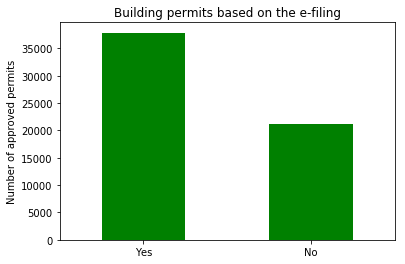

In [33]:
# Create a histogram of Efiling and include a statistical analysis.
ax = data['Efiling Filed'].value_counts().plot(kind='bar', color='g')
ax.set_xticklabels(['Yes','No'],rotation=360)
ax.set_title('Building permits based on the e-filing')
ax.set_ylabel('Number of approved permits')
pd.DataFrame(data['Efiling Filed'].value_counts().describe())
plt.tight_layout()

,count,mean,std,min,25%,50%,75%,max
Efiling Filed,,,,,,,,
N,37875.0,136.489927,251.178401,1.0,10.0,55.0,149.0,4959.0
Y,21203.0,221.965335,265.440947,1.0,63.0,139.0,276.0,3585.0


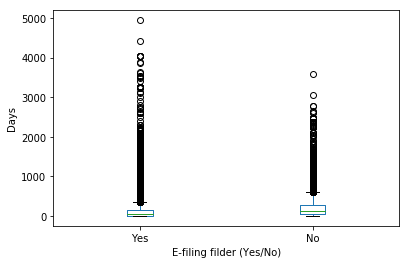

In [34]:
ax = data.boxplot(column=['Duration'], by=['Efiling Filed'])
ax.set_title('')
ax.set_ylabel('Days')
ax.set_xlabel('E-filing filder (Yes/No)')
ax.set_xticklabels(['Yes','No'])
plt.suptitle('')
ax.grid(False)
pd.DataFrame(data.groupby(['Efiling Filed'])['Duration'].describe())
plt.tight_layout()

,count,mean,std,min,25%,50%,75%,max
Applicant Professional Title,,,,,,,,
PE,14990.0,142.513342,229.342644,1.0,22.0,66.0,168.0,4959.0
RA,44088.0,175.549174,268.658088,1.0,27.0,89.0,211.0,4411.0


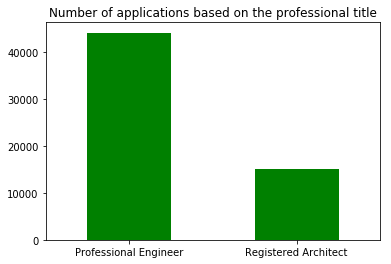

In [35]:
# Create a bar chart of Professional Title and include a statistical analysis.
ax = data['Applicant Professional Title'].value_counts().plot(kind='bar', color='g')
ax.set_xticklabels(['Professional Engineer','Registered Architect'],rotation=360)
ax.set_title('Number of applications based on the professional title')
pd.DataFrame(data.groupby('Applicant Professional Title')['Duration'].describe())

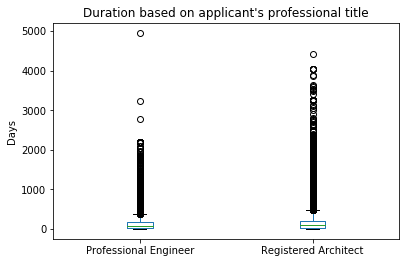

In [36]:
# Boxplot of Duration based on the applicants' professional title.
ax = data.boxplot(column=['Duration'], by=['Applicant Professional Title'])
ax.set_xticklabels(['Professional Engineer','Registered Architect'])
plt.suptitle('')
ax.set_title("Duration based on applicant's professional title")
ax.set_xlabel('')
ax.set_ylabel('Days')
ax.grid(False)
plt.tight_layout()

,count,mean,std,min,25%,50%,75%,max
Professional Cert,,,,,,,,
N,38010.0,225.441594,282.962780,1.0,71.0,138.0,267.0,4959.0
Y,21066.0,62.025966,165.562255,1.0,3.0,13.0,42.0,2589.0


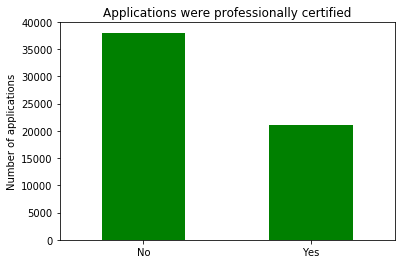

In [68]:
# Bar chart indicating whether or not the application was submitted as 
# Professionally Certified by a Professional Engineer (PE) or Registered Architect (RA).
ax = data['Professional Cert'].value_counts().plot(kind='bar', color='g')
ax.set_xticklabels(['No','Yes'],rotation=360)
ax.set_title('Applications were professionally certified')
ax.set_ylabel('Number of applications')
pd.DataFrame(data.groupby('Professional Cert')['Duration'].describe())


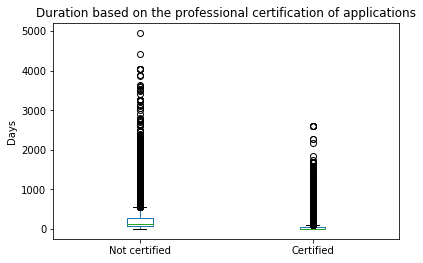

In [69]:
# Boxplot of Duration based on wheather or not the applications were professionally certified.
ax = data.boxplot(column=['Duration'], by=['Professional Cert'])
ax.set_xticklabels(['Not certified','Certified'])
plt.suptitle('')
ax.set_title("Duration based on the professional certification of applications")
ax.set_xlabel('')
ax.set_ylabel('Days')
ax.grid(False)
plt.tight_layout()

In [ ]:
# Bar chart indicating whether or not the application was submitted as 
# Professionally Certified by a Professional Engineer (PE) or Registered Architect (RA).
ax = data[' '].value_counts().plot(kind='bar', color='g')
ax.set_xticklabels(['No','Yes'],rotation=360)
ax.set_title('Applications were professionally certified')
ax.set_ylabel('Number of applications')
pd.DataFrame(data.groupby(' ')['Duration'].describe())
plt.tight_layout()

,Total Est. Fee
count,59076.0
mean,3950.3
std,84871.4
min,0.0
25%,376.8
50%,613.8
75%,1168.3
max,16900000.0


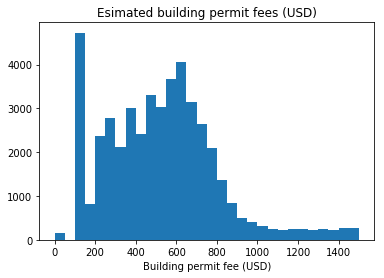

In [118]:
# Histogram of building permit fee () 
ax = data['Total Est. Fee'].hist(bins=30, range=(0,1500))
ax.set_title('Esimated building permit fees (USD)')
ax.set_xlabel('Building permit fee (USD)')
ax.grid(False)
pd.DataFrame((data['Total Est. Fee']).describe()).round(1)
plt.tight_layout()

Text(0.5,0,'')

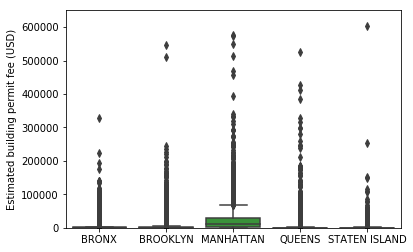

In [223]:
# Boxplot of building permit fee (estimated) in each borough.
ax = sns.boxplot(data=data,x='Borough',y='Total Est. Fee')
ax.set_ylabel('Estimated building permit fee (USD)')
plt.ylim(0,650000)
ax.set_xlabel('')
plt.tight_layout()

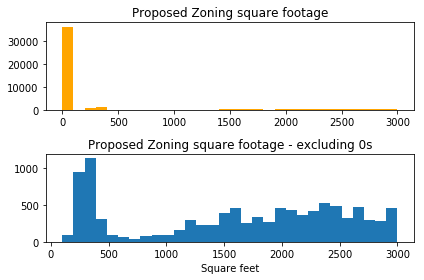

In [258]:
# Histogram of Proposed Zoning square footage. 
fig, ax = plt.subplots(2,1)

plt.subplot(2,1,1)
ax = data['Proposed Zoning Sqft'].hist(bins=30, range=(0,3000), color='orange')
ax.set_title('Proposed Zoning square footage')
# ax.set_xlabel('Square feet')
ax.grid(False)
pd.DataFrame((data['Proposed Zoning Sqft']).describe()).round(1)

plt.subplot(2,1,2)
ax1 = data['Proposed Zoning Sqft'].hist(bins=30, range=(100,3000))
ax1.set_title('Proposed Zoning square footage - excluding 0s')
ax1.set_xlabel('Square feet')
ax1.grid(False)
plt.tight_layout()

,Proposed No. Of Stories
count,59076.0
mean,3.3
std,4.1
min,0.0
25%,2.0
50%,3.0
75%,3.0
max,212.0


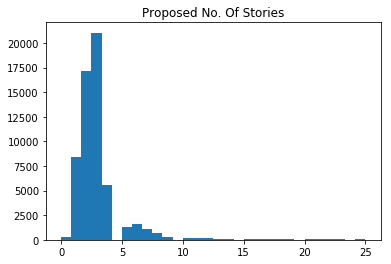

In [270]:
# Histogram of Proposed No. Of Stories. 
ax = data['Proposed No. Of Stories'].hist(bins=30, range=(0,25))
ax.set_title('Proposed No. Of Stories')
ax.set_xlabel('')
ax.grid(False)
pd.DataFrame((data['Proposed No. Of Stories']).describe()).round(1)
plt.tight_layout()

Text(0.5,0,'')

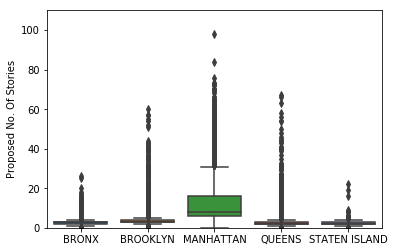

In [286]:
# Boxplot of Proposed No. Of Stories in each borough. 
ax = sns.boxplot(data=data,x='Borough', y='Proposed No. Of Stories')
ax.set(ylim=(0,110))
ax.set_xlabel('')
plt.tight_layout()

,Proposed Height
count,59076.0
mean,36.8
std,57.1
min,0.0
25%,23.0
50%,28.0
75%,35.0
max,7310.0


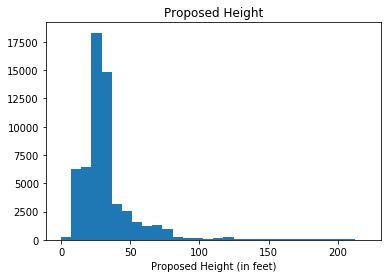

In [296]:
# Histogram of Proposed Height. 
ax = data['Proposed Height'].hist(bins=30, range=(0,220))
ax.set_title('Proposed Height')
ax.set_xlabel('Proposed Height (in feet)')
ax.grid(False)
pd.DataFrame((data['Proposed Height']).describe()).round(1)
plt.tight_layout()

Text(0.5,1,'Proposed Height in each borough')

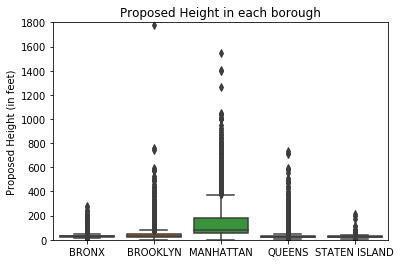

In [307]:
# Boxplot of Proposed Height in each borough. 
ax = sns.boxplot(data=data,x='Borough', y='Proposed Height')
ax.set(ylim=(0,1800))
ax.set_xlabel('')
ax.set_ylabel('Proposed Height (in feet)')
ax.set_title('Proposed Height in each borough')
plt.tight_layout()

,Proposed Dwelling Units
count,50387.0
mean,10.1
std,103.1
min,0.0
25%,1.0
50%,2.0
75%,3.0
max,21240.0


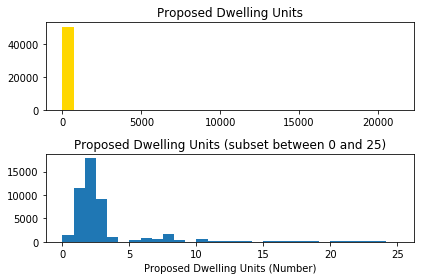

In [317]:
# Histogram of Proposed Height. 
fig,ax = plt.subplots(2,1, sharey=True)
plt.subplot(2,1,1)
ax = data['Proposed Dwelling Units'].hist(bins=30, color='gold')
ax.set_title('Proposed Dwelling Units')
# ax.set_xlabel('Proposed Dwelling Units (Number)')
ax.grid(False)

plt.subplot(2,1,2)
ax1 = data['Proposed Dwelling Units'].hist(bins=30, range=(0,25))
ax1.set_title('Proposed Dwelling Units (subset between 0 and 25)')
ax1.set_xlabel('Proposed Dwelling Units (Number)')
ax1.grid(False)

plt.tight_layout()
pd.DataFrame((data['Proposed Dwelling Units']).describe()).round(1)

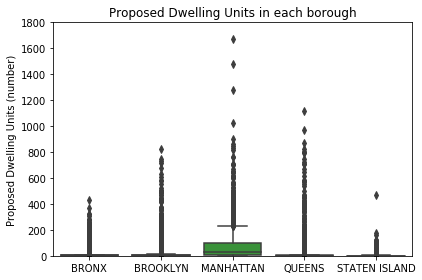

In [320]:
# Boxplot of Proposed Height in each borough. 
ax = sns.boxplot(data=data,x='Borough', y='Proposed Dwelling Units')
ax.set(ylim=(0,1800))
ax.set_xlabel('')
ax.set_ylabel('Proposed Dwelling Units (number)')
ax.set_title('Proposed Dwelling Units in each borough')
plt.tight_layout()

In [329]:
# bar chart of Proposed Occupancy.

data.groupby('Proposed Occupancy')['Duration'].mean().sort_values()

Proposed Occupancy
B-2      71.850017
H-5      92.000000
A       111.000000
J-0     114.710769
U       117.154720
J-3     117.801740
K       119.365854
A-5     123.600000
RES     141.927762
D-1     150.741667
S-2     156.524931
B-1     167.840000
F-4     174.388889
J-2     195.413098
C       198.897474
COM     199.940299
PUB     200.826087
D-2     209.824818
R-3     213.261523
E       226.938889
F-1     230.692308
F-1A    250.500000
R-2     267.597951
F-2     268.760000
A-2     273.854545
M       273.860784
S-1     284.056738
F-1B    306.482993
B       309.755932
G       327.448485
J-1     346.995215
H-2     357.500000
R-1     365.405556
A-4     396.400000
I-1     401.000000
I-2     413.583333
F-3     422.416667
A-3     449.773723
I-4     457.000000
H-1     531.833333
A-1     600.142857
H-3     674.000000
Name: Duration, dtype: float64

### Categorical variables that have multiple categories 

#### How to visualize the categorigal variables that have too many categories for a bar chart or box plot?

Zoning, Special Districts and Proposed Occupany variables have multiple categoris each, ranging from 8 (Special District 2) to 43 (Proposed Occupancy) to 164 (Zoning Dist1) and anything in between. 

In [337]:
data['Proposed Occupancy'].unique()

array(['R-3', 'R-1', 'U', 'R-2', 'E', 'M', 'S-2', 'J-3', 'B', 'S-1',
       'B-2', 'F-1', 'J-2', 'F-1B', 'A-3', 'J-0', 'A-4', 'PUB', 'C',
       'B-1', 'G', 'RES', 'J-1', nan, 'A-5', 'I-1', 'A-2', 'F-2', 'F-3',
       'COM', 'D-1', 'D-2', 'H-2', 'K', 'F-4', 'I-2', 'I-4', 'F-1A', 'A',
       'H-5', 'A-1', 'H-1', 'H-3'], dtype=object)

,Total_Construction_Floor_Area
count,59076.0
mean,13557.1
std,70007.6
min,0.0
25%,2319.0
50%,3453.0
75%,5481.2
max,7142400.0


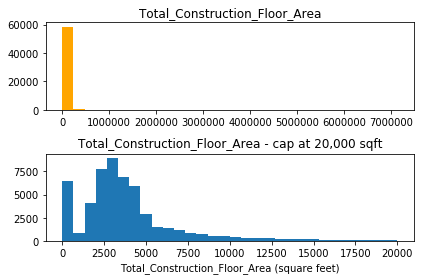

In [357]:
# Histogram of Proposed Height. 

fig,ax = plt.subplots(2,1)

plt.subplot(2,1,1)
ax = data['Total_Construction_Floor_Area'].hist(bins=30, color='orange')
ax.set_title('Total_Construction_Floor_Area')
# ax.set_xlabel('Total_Construction_Floor_Area (square feet)')
ax.grid(False)

plt.subplot(2,1,2)
ax1 = data['Total_Construction_Floor_Area'].hist(bins=30,  range=(0,20000))
ax1.set_title('Total_Construction_Floor_Area - cap at 20,000 sqft')
ax1.set_xlabel('Total_Construction_Floor_Area (square feet)')
ax1.grid(False)


plt.tight_layout()
pd.DataFrame((data['Total_Construction_Floor_Area']).describe()).round(1)


count    59076.000000
mean       167.168969
std        259.648127
min          1.000000
25%         25.000000
50%         83.000000
75%        201.000000
max       4959.000000
Name: Duration, dtype: float64

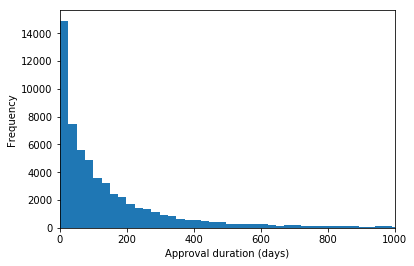

In [363]:
# Create a histogram of duration and include a statistical analysis.
data['Duration'].plot(kind='hist', bins = 200)
plt.xlim(0,1000)
plt.xlabel('Approval duration (days)')
data['Duration'].describe()

Text(0,0.5,'Average days for approval')

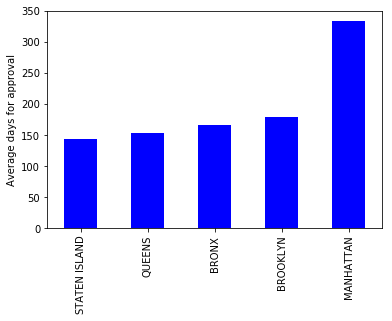

In [364]:
# Duration of the approval in each borough. 
data.groupby('Borough')['Duration'].mean().sort_values().plot(kind='bar', color = 'blue')
plt.xlabel('')
plt.ylabel('Average days for approval')

In [321]:
data.iloc[:,5:].head(2)

,Pre- Filing Date,Fully Paid,Approved,Fully Permitted,Total Est. Fee,Proposed Zoning Sqft,Proposed No. Of Stories,Proposed Height,Proposed Dwelling Units,Proposed Occupancy,Zoning Dist1,Zoning Dist2,Zoning Dist3,Special District 1,Special District 2,Non-Profit,Total_Construction_Floor_Area,Signoff_Date,Duration
0,2018-11-02,2018-11-02,2019-04-09,NaT,243.00,2700,2,28,2.0,R-3,R3A,NaN,NaN,NaN,NaN,N,4050,NaT,158.0
1,2012-03-23,2012-03-27,2013-03-14,2014-11-13,52167.26,161567,14,150,234.0,R-1,M1-2/R6,NaN,NaN,MX-8,GW,N,198951,NaT,352.0


In [ ]:
data['TOTAL_CONSTRUCTION_FLOOR_AREA'].mean()

In [ ]:
data.head(2)

In [ ]:
data.groupby('Building Type')['Duration'].mean().plot(kind='bar')

In [ ]:
# transform the Boroughs into categories for faster analysis.
data['Borough'] = data['Borough'].astype('category')

In [ ]:
(data.groupby(['Borough','Building Type'])['Total_Construction_Floor_Area'].
 sum().sort_values().plot(kind='bar',color='green'))

In [ ]:
normal_data.iloc[:,4:18]

In [ ]:
agg=(data.groupby('Borough')
 ['Total_Construction_Floor_Area']
     .agg(['mean','median']).round(0))

In [ ]:
agg.plot(kind='bar')
plt.xlabel('')
plt.ylabel('Total construction area (sqf)')

In [ ]:
agg1 =(data.groupby('Efiling Filed')
 [['Duration','Total_Construction_Floor_Area']].agg(['mean','median']))

In [ ]:
ax = agg1['Duration'].plot(kind='bar')
ax.set_xlabel('Electronic filing')
ax.set_ylabel('Approval duration (days)')
ax.set_xticklabels(['Yes','No'],rotation=360)
ax.legend(loc='upper left')

In [ ]:
data.head(2)

In [ ]:
x = data.set_index(['Proposed Occupancy','Borough'])

In [ ]:
x.groupby(level=['Borough']).mean()

In [ ]:
data.head(2)

### Selecting outliers

Selecting outliers based on the Total_Construction_Floor_Area variable. Applying a filter to
select values that are +- 3 standard deviation in this variable. Total number of outliers is
517 data points, which is 0.08% of the total data.

In [ ]:
from scipy.stats import zscore

In [ ]:
standardized = (normal_data.
                groupby('Borough')['Total_Construction_Floor_Area'].transform(zscore))

In [ ]:
outliers = standardized[(standardized > 3) | (standardized < -3)]

In [ ]:
outlier_data = data.iloc[outliers]

In [ ]:
outlier_data

In [287]:
ax = (outlier_data.groupby('Borough').mean()
      ['Duration'].sort_values().plot(kind='bar', color='b'))

ax.set_ylabel('Duration (days)')
ax.set_xlabel('')

NameError: name 'outlier_data' is not defined

In [ ]:
data.head(2)

In [ ]:
by_boro_data = (data.groupby(
    ['Borough','Pre- Filing Date'])['Duration']).agg(['median', 'max', 'min'])

In [ ]:
by_boro_data.groupby('Borough').mean().plot(kind='bar')
# by_boro_data.loc['QUEENS']['Duration'].plot(kind='hist', bins=50, color='yellow',alpha=0.5)
# by_boro_data.loc['MANHATTAN']['Duration'].plot(kind='hist', bins=50, color='red',alpha=0.5)
# plt.subplots
# plt.xlim(0,800)
